<a href="https://colab.research.google.com/github/harish-babu/stash-ai-ml-models/blob/main/Harish_Babu_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
!rm -f ./kaggle-flickr8k/features/*

In [2]:
!pip install pydot

In [3]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00


In [4]:
!wget -q https://www.kaggle.com/api/v1/datasets/download/adityajn105/flickr8k --output-document="flickr8k.zip"

In [5]:
# Importing necessary libraries for data manipulation and analysis
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split

# Importing library for displaying progress bars
from tqdm import tqdm

# Importing libraries for Natural Language Processing (NLP) tasks
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu

# Importing libraries for building and training deep learning models
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences

# Importing libraries for building deep learning models (various layers and optimizers)
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector
from keras.layers import Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers

from PIL import Image
from io import BytesIO
import base64
from IPython.display import HTML

import re
import gc


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's read the dataset

## 1. Data understanding
1. Import the dataset and read image & captions into two seperate variables
2. Visualise both the images & text present in the dataset
3. Create a dataframe which summarizes the image, path & captions as a dataframe
4. Create a list which contains all the captions & path
5. Visualise the top 30 occuring words in the captions

In [6]:
# Source Path of the kaggle dataset file.
# If it is gdrive, then it will point to that.  If it is in local, it will show that.
# Make sure you mount the google drive in /content/gdrive
file_name = 'flickr8k.zip'
zip_file_src_path = './'                                                        # For running from Google Drive

In [7]:
base_path = './kaggle-flickr8k/'

In [8]:
from zipfile import ZipFile
with ZipFile(zip_file_src_path + '/' + file_name,'r') as zip_file:
  zip_file.extractall(base_path)

In [9]:
# Defining paths
BASE_PATH = "./kaggle-flickr8k/"
IMAGE_PATH = BASE_PATH + 'Images/'
CAPTIONS_FILE = BASE_PATH + 'captions.txt'
OUTPUT_IMAGE_PATH = BASE_PATH + "working/Image/"

##### 1.1 Import the dataset and read the image into a seperate variable

In [10]:
images=IMAGE_PATH

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


##### 1.2 Visualise both the images & text present in the dataset

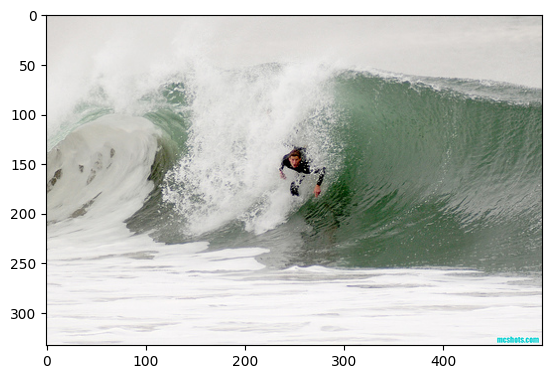

In [11]:
# First image
plt.imshow(mpimg.imread(all_imgs[0]))

In [12]:
# Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    """
    Load a document from a file and split each line into a list of two columns.

    Args:
        filename (str): The name of the file to load.

    Returns:
        list: A list of lists, where each sublist contains two columns.
    """
    with open(filename, 'r') as f_in:
        return [line.rstrip().split(",", maxsplit=1) for line in f_in if line.strip()]

doc = load_doc(CAPTIONS_FILE)
print(doc[:30])

[['image', 'caption'], ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'], ['1001773457_577c3a7d70.jpg', 'A black dog and a tri-colored dog playing with each other on the road .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a white dog with brown spots are staring at each other in the street .'], ['1001773457_577c3a7d70.jpg', 'Two dogs of different breeds looking at each other on the road .'], ['1001773457_577c3a7d70.jpg', 'Two dogs on pavement moving toward each other .'], ['1002674143_1b742ab4b8.jpg', 'A little girl covere

##### 1.3 Create a dataframe which summarizes the image, path & captions as a dataframe
     
Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [13]:
# Initialize an empty list to store the data
data = []

# Read the captions file
with open(CAPTIONS_FILE, 'r') as f:
    # Skip the header line
    next(f)
    for line in f:
        # Split the line into image ID and caption
        image_id, caption = line.strip().split(',', 1)

        # Extract the image ID without the file extension
        image_id = image_id.split('.')[0]

        # Append the data to the list
        data.append({
            'image_id': image_id,
            'image_path': os.path.join(IMAGE_PATH, f'{image_id}.jpg'),
            'caption': caption
        })

# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

# Print the first few rows of the DataFrame
df.head()

image_id                                         image_path  \
0  1000268201_693b08cb0e  ./kaggle-flickr8k/Images/1000268201_693b08cb0e...   
1  1000268201_693b08cb0e  ./kaggle-flickr8k/Images/1000268201_693b08cb0e...   
2  1000268201_693b08cb0e  ./kaggle-flickr8k/Images/1000268201_693b08cb0e...   
3  1000268201_693b08cb0e  ./kaggle-flickr8k/Images/1000268201_693b08cb0e...   
4  1000268201_693b08cb0e  ./kaggle-flickr8k/Images/1000268201_693b08cb0e...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [14]:
# Print size of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    40455 non-null  object
 1   image_path  40455 non-null  object
 2   caption     40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [15]:
# Define a few helper functions
def get_image_thumbnail(path):
    """Opens an image file and returns the image object."""
    return Image.open(path)

def convert_image_to_base64(image):
    """Converts an image object or path to a base64 encoded string."""
    if isinstance(image, str):
        image = get_image_thumbnail(image)

    with BytesIO() as buffer:
        image.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def format_image_as_html(image):
    """Returns an HTML string representing the image."""
    base64_image = convert_image_to_base64(image)
    return f'<img src="data:image/jpeg;base64,{base64_image}" style="max-height:124px;">'

In [16]:
df_img = pd.DataFrame(zip([get_image_thumbnail(i) for i in df.image_path.head().to_list()], df.caption.head()), columns=['Images', 'Captions'])


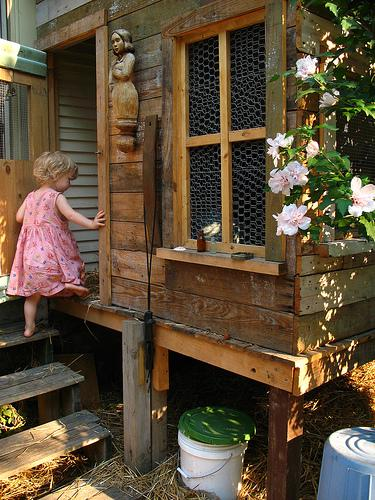
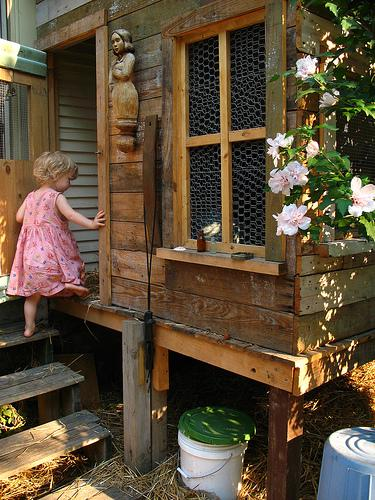
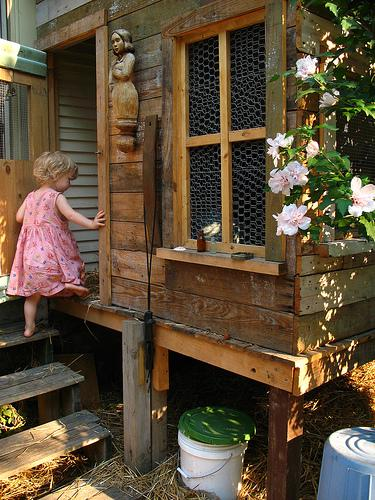
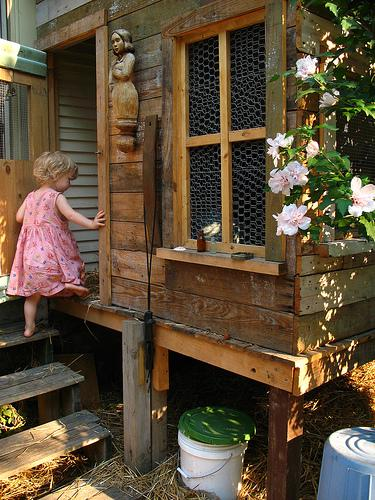
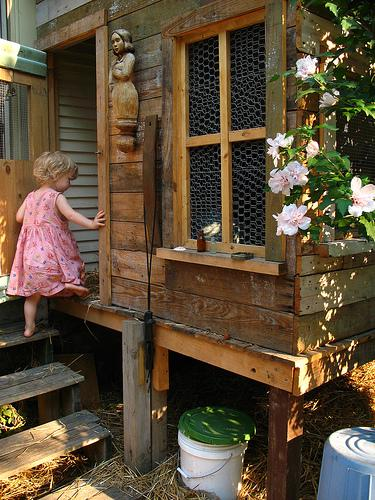

In [17]:
#Mapping of Image and Caption
HTML(df_img.to_html(formatters={'Images': format_image_as_html}, escape=False))

In [18]:
def caption_and_image_plotter(image_id, frame):
    # Get captions and image path
    image_row = frame[frame['image_id'] == image_id]
    caps = ("\n"*2).join(image_row['caption'].to_list())
    image_path = image_row['image_path'].iloc[0]

    # Create a plot
    fig, ax = plt.subplots()
    ax.set_axis_off()

    # Open and display image
    im = Image.open(image_path)
    w, h = im.size[0], im.size[-1]
    ax.imshow(im)

    # Add captions
    ax.text(w+50, h, caps, fontsize=20, color='green')

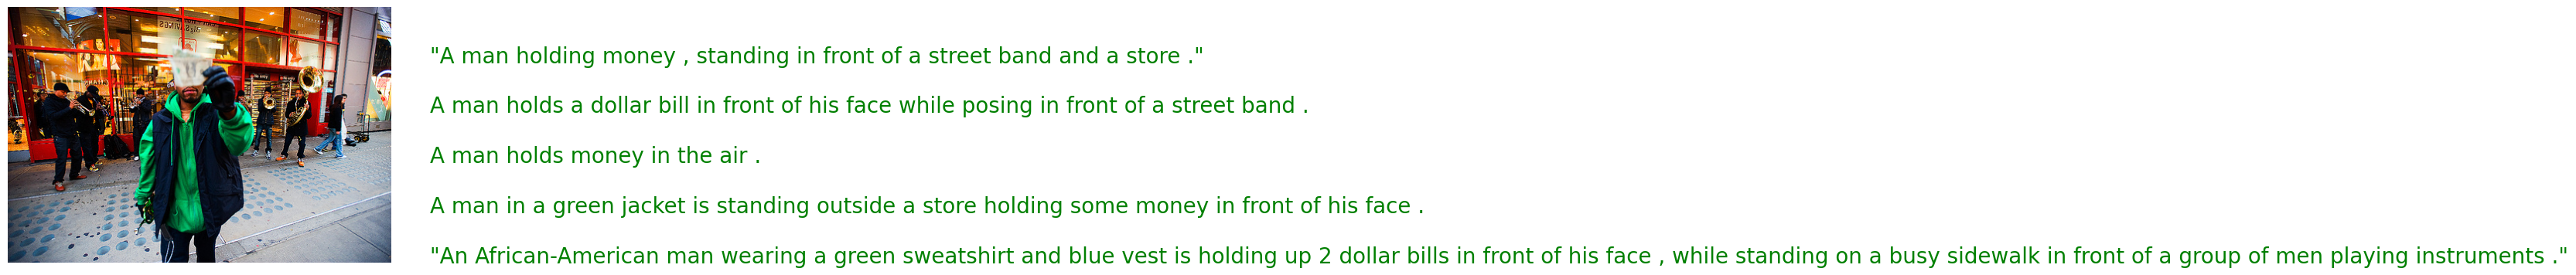

In [19]:
caption_and_image_plotter(df.image_id.iloc[8049],df)

In [20]:
def plt_few_images(start, end, frame):
    unique_ids = frame['image_id'].drop_duplicates()
    for image_id in unique_ids.iloc[start:end]:
        caption_and_image_plotter(image_id, frame)

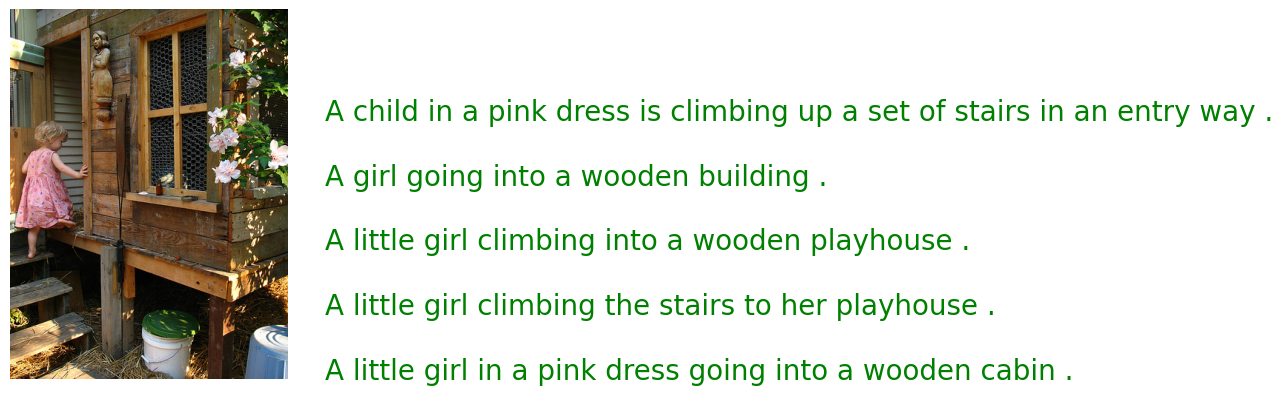

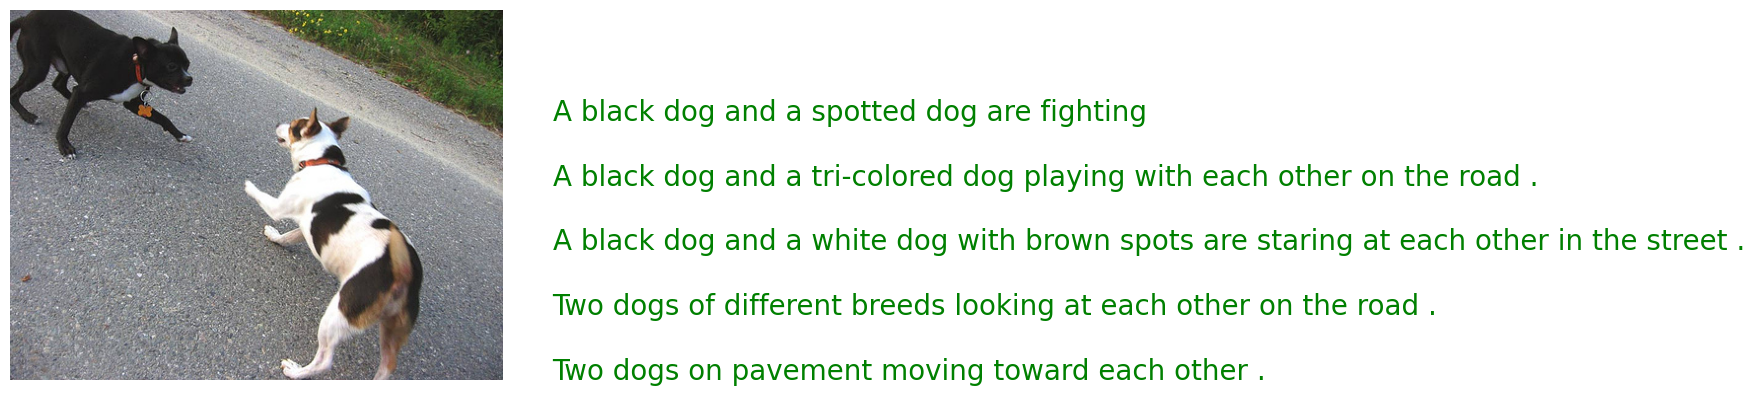

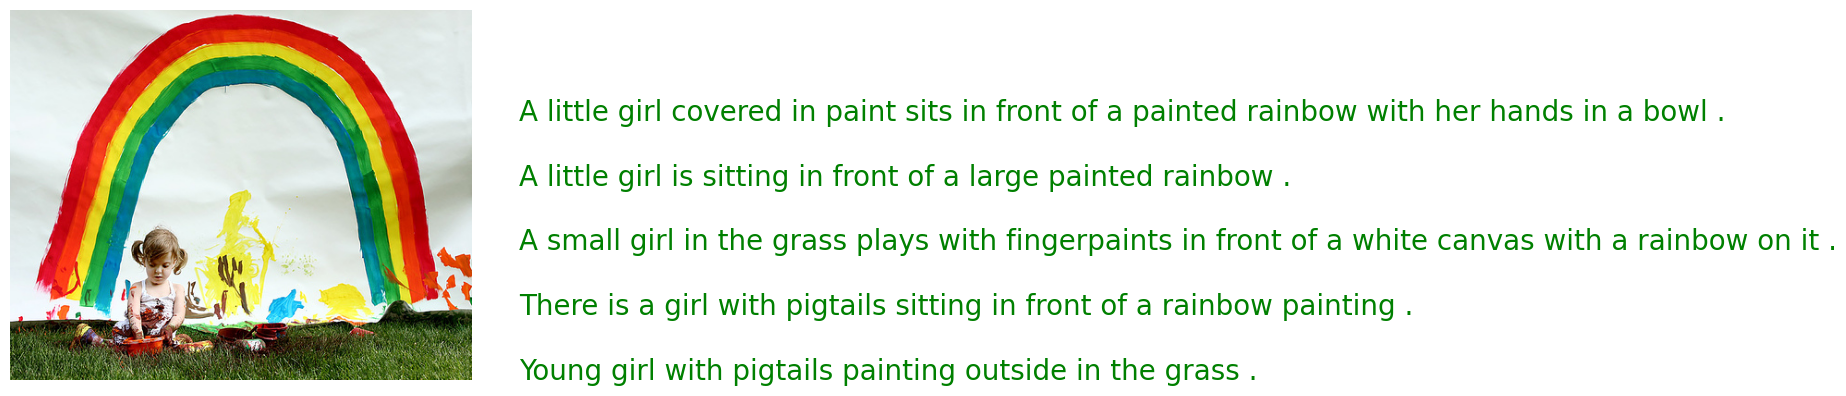

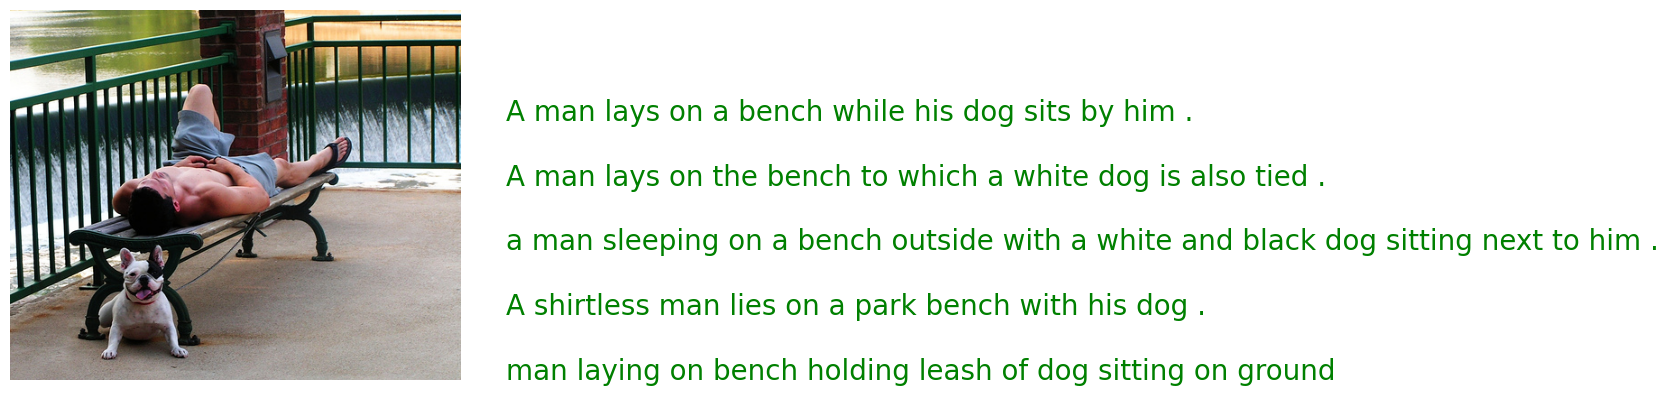

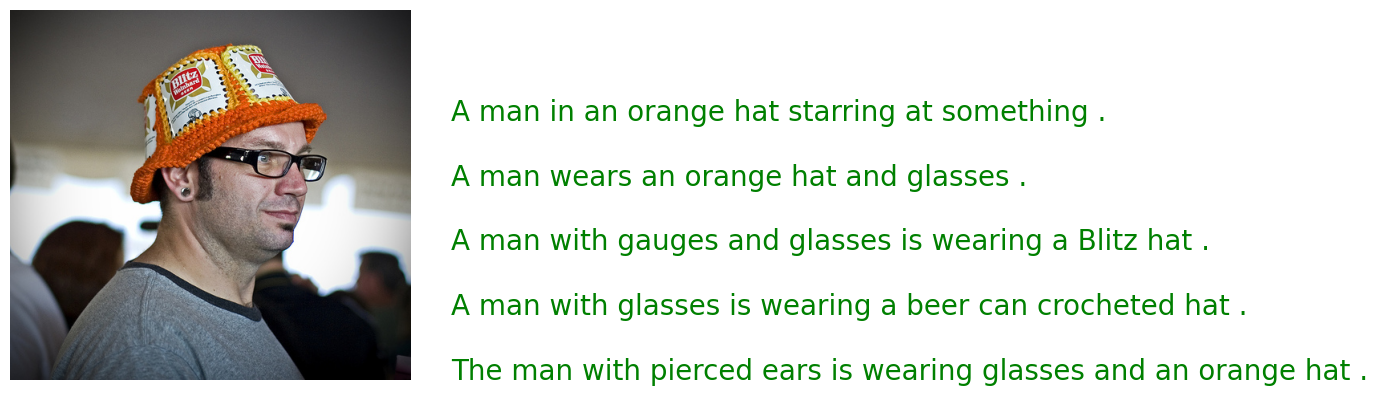

In [21]:
plt_few_images(0,5,df)

##### 1.4 Create a list which contains all the captions & path

In [22]:

# Create a list which contains all the captions
annotations=[]

# Add the <start> & <end> token to all those captions as well
for cap in df.caption:
    cap='<start> '+ cap + ' <end>'
    annotations.append(cap)


#Create a list which contains all the path to the images
all_img_path=df.image_path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


##### 1.5 Visualise the top 30 occuring words in the captions

In [23]:
# Create the vocabulary & the counter for the captions
vocabulary = []
for cap in df.caption.values:
        vocabulary.extend(cap.split())

val_count = Counter(vocabulary)
print("Size of Vocab : ",len(set(vocabulary)))

Size of Vocab :  9862


##### 1.5 Visualise the top 30 occuring words in the captions


In [24]:
# Helper functions

# Plot the word count
def plot_word_count(wordCountList):
    if not wordCountList:
        print("Error: wordCountList is empty")
        return
    word_list, wc_list = zip(*wordCountList)
    plt.figure(figsize=(20,6))
    sns.set_style('whitegrid')
    sns.barplot(x=list(word_list), y=list(wc_list), palette='tab10', orient='v')
    plt.title('Top 30 Occurring Words', fontsize=18)
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

<ipython-input-24-1cbb82bbf9bf>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_list), y=list(wc_list), palette='tab10', orient='v')


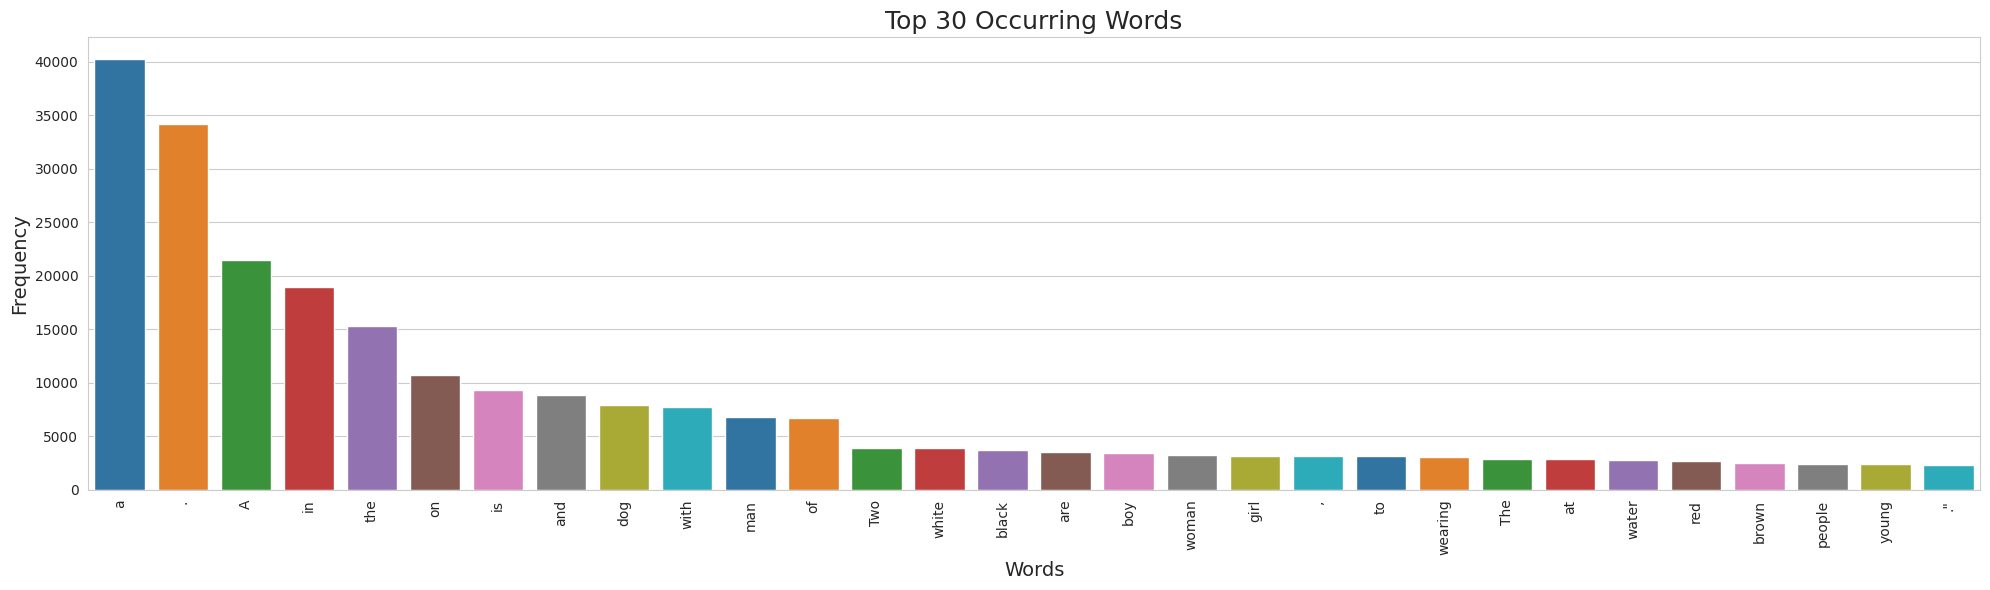

In [25]:
sorted_list = val_count.most_common(30)
plot_word_count(sorted_list)

## 2. Pre-Processing the captions
1. Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocabulary to top 5,000 words for saving memory.
2. Replace all other words with the unknown token "UNK" .
3. Create word-to-index and index-to-word mappings.
4. Pad all sequences to be the same length as the longest one.

##### 2.1 Create the tokenizer

In [26]:
TOP_WORDS_COUNT = 5000

filter_chars = '[!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_WORDS_COUNT, oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [27]:
print(train_seqs[:5])
print(annotations[:5])

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']


##### 2.2 Create word-to-index and index-to-word mappings.

In [28]:
# Create word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [29]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [30]:
# Encode training data sentences into sequences
train_seqs  = tokenizer.texts_to_sequences(annotations)

In [31]:
print(train_seqs[1])
print(annotations[1])

[3, 2, 20, 317, 65, 2, 197, 118, 4]
<start> A girl going into a wooden building . <end>


##### 2.3 Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

In [32]:
word_counts = Counter(tokenizer.word_counts)
sorted_word_counts = word_counts.most_common()

<ipython-input-24-1cbb82bbf9bf>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_list), y=list(wc_list), palette='tab10', orient='v')


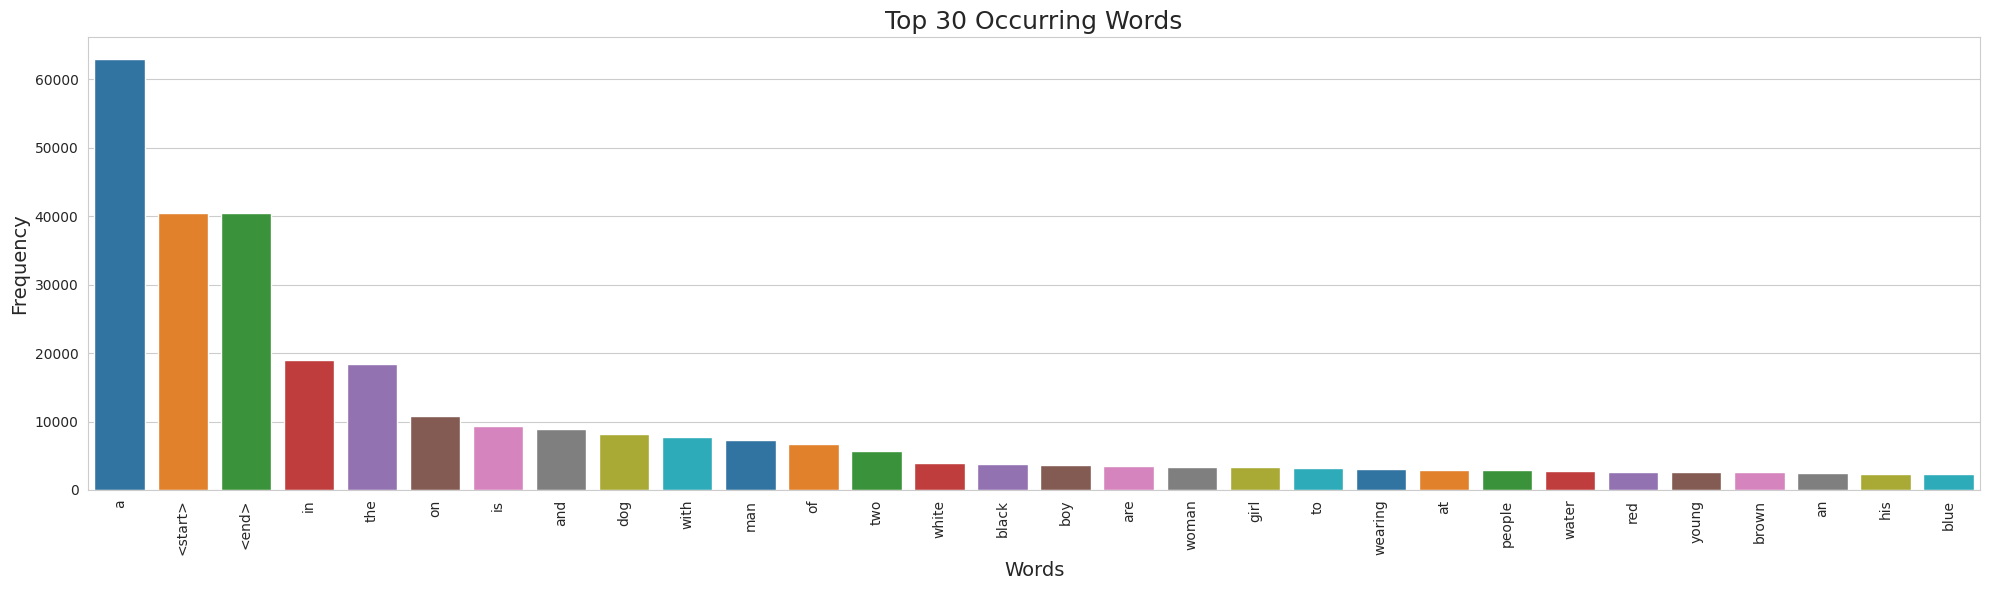

In [33]:
plot_word_count(sorted_word_counts[:30])

##### 2.4 Pad each vector to the max_length of the captions & store it to a variable

In [34]:
max_length = max([len(t) for t in train_seqs])
print("The maximum length of a sentence in the annotation dataset is: " + str(max_length))

The maximum length of a sentence in the annotation dataset is: 39


In [35]:
caption_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)

In [36]:
print("The shape of Caption vector is :" + str(caption_vector.shape))

The shape of Caption vector is :(40455, 39)


## 3. Pre-processing the images

1. Resize them into the shape of (299, 299)
2. Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [37]:
# Write your code here to create the dataset consisting of image paths
image_paths_list = df['image_path'].values.tolist()
unique_image_path_list = list(dict.fromkeys(df['image_path']))

In [38]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image, image_path

In [39]:
# Let's test the function
print("Path -",(image_paths_list[20]))
print("Shape after resize :", load_image(image_paths_list[20])[0].shape)

Path - ./kaggle-flickr8k/Images/1007129816_e794419615.jpg
Shape after resize : (299, 299, 3)


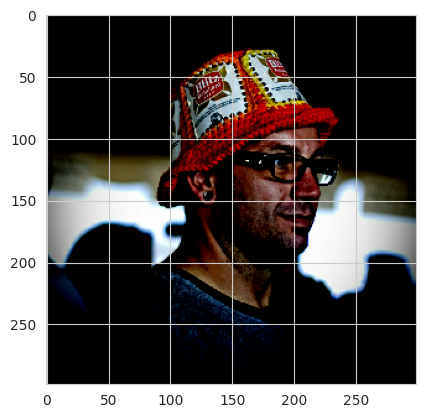

In [40]:
plt.imshow(load_image(image_paths_list[20])[0])

In [41]:
print(len(unique_image_path_list))

8091


In [42]:
# Write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

BATCH_SIZE = 64
image_dataset = tf.data.Dataset.from_tensor_slices(unique_image_path_list).map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)



In [43]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [44]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## 4. Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



#### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

In [45]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input                              # Get the input of the image_model
hidden_layer = image_model.layers[-1].output               # Get the output of the image_model

# Getting the Pretrained Model Weights
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
image_features_extract_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [47]:
keras.utils.plot_model(image_model, "image_model.png", show_shapes=True)

In [48]:
gc.collect()


111914

In [49]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_dict = {}
from tqdm import tqdm
os.makedirs(BASE_PATH + 'features')
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        image_full_path = p.numpy().decode("utf-8")
        image_path_base = os.path.basename(image_full_path)
        path_of_feature = BASE_PATH + 'features/' +  image_path_base
        np.save(path_of_feature, bf.numpy())


100%|██████████| 127/127 [01:24<00:00,  1.51it/s]


## 5. Dataset creation
1. Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42
2. Create a function which maps the image path to their feature.
3. Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset
4. Make sure you have done Shuffle and batch while building the dataset
5. The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)
6. The shape of each caption in the dataset after building should be(batch_size, max_len)


In [50]:
# Split Train & Test
path_train, path_test, cap_train, cap_test = train_test_split (image_paths_list,caption_vector,test_size=0.2,random_state=101)

In [51]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


[   3   48 2140    7    2  401  140    4    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
<start> three passengers on a train car <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


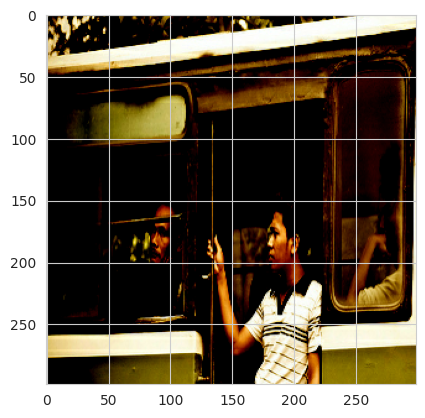

In [52]:
# Visualize one image
print(cap_test[5])
print(" ".join(tokenizer.index_word[i] for i in cap_test[5]))
plt.imshow(load_image(path_test[5])[0])


In [53]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_path, caption):
    image_full_path = image_path.numpy().decode("utf-8")
    image_path_base = os.path.basename(image_full_path)
    path_of_feature = BASE_PATH + 'features/' +  image_path_base
    img_tensor = np.load(path_of_feature+'.npy')
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [54]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image,caption, batch_size=32, buffer_size=1000):

    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    #dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [55]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [56]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [57]:
# Define a few constants
BATCH_SIZE = 32
embedding_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

In [58]:
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### Encoder

In [59]:
# Define the Encoder
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features)
        features = tf.nn.relu(features)

        return features

In [60]:
encoder=Encoder(embedding_dim)

### Attention model

In [61]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)                                       # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))   # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)                # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features                                           #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1)                                # reduce the shape to (batch_size, embedding_dim)


        return context_vector, attention_weights

### Decoder

In [73]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5) #Adding Dropouts


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x))# embed your input to shape: (batch_size, 1, embedding_dim)
        # mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        gru_output = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        print(gru_output[0].shape)
        print(gru_output[1].shape)
        output = gru_output[0]
        state = gru_output[1]
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [74]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [75]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))                  #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape))           #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))   #(batch, 8*8, embed_dim)

(32, 1, 512)
(512,)
Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [76]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [77]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [78]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [79]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [80]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [84]:
print(tf.__version__)

2.17.0


In [81]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            #predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            predicted_id = tf.argmax(predictions,1)
            # Not using teacher forcing since test dataset
            #dec_input = tf.expand_dims([predicted_id]* target.shape[0], 1)
            #dec_input = tf.expand_dims(target[:, i], 1)
            dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [82]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps

    return avg_test_loss

In [83]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:02<?, ?it/s]


TypeError: in user code:

    File "<ipython-input-69-b2c05db0a6a7>", line 12, in train_step  *
        predictions, hidden, _ = decoder(dec_input, features, hidden)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-73-8a412b099b1b>", line 18, in call
        gru_output = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)

    TypeError: Exception encountered when calling GRU.call().
    
    [1mlen is not well defined for a symbolic Tensor (decoder_1_1/gru_1_1/Squeeze:0). Please call `x.shape` rather than `len(x)` for shape information.[0m
    
    Arguments received by GRU.call():
      • sequences=tf.Tensor(shape=(32, 1, 512), dtype=float32)
      • initial_state=None
      • mask=None
      • training=False


In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search

    return final_caption



In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)